# Multi-User Queries

This notebook is to measure the impact of multi-user queries on the performance of the system.

First prepare the Geo Engine Instances to test against.

You will need to open ports in the firewall.

```bash
sudo iptables -A NETUNI -p tcp -m tcp --dport 18001 -m comment --comment "GE Test 1" -j ACCEPT \
sudo iptables -A NETUNI -p tcp -m tcp --dport 18002 -m comment --comment "GE Test 2" -j ACCEPT \
sudo iptables -A NETUNI -p tcp -m tcp --dport 18003 -m comment --comment "GE Test 3" -j ACCEPT \
```

Then start the Geo Engine Instances with specific ressources on the ports:

```bash
podman run -d --rm --cpuset-mems=0 --cpus=8 --memory=16G --name=ge_test_1 -p 18001:8080 "quay.io/geoengine/geoengine:pro-nightly"
podman run -d --rm --cpuset-mems=0 --cpus=16 --memory=32G --name=ge_test_2 -p 18002:8080 "quay.io/geoengine/geoengine:pro-nightly"
podman run -d --rm --cpuset-mems=0 --cpus=32 --memory=64G --name=ge_test_3 -p 18003:8080 "quay.io/geoengine/geoengine:pro-nightly"
```

In [61]:
import geoengine as ge
import datetime as dt
import multiprocessing as mp
from typing import Tuple, Any, Dict


Create dicts with the instances to test against.


In [62]:
test_instances = {
    "test_1": {
        "url": "http://pc12737.mathematik.uni-marburg.de:18001/api",
        "cpus": 8,
        "memory": 16,
    },
    "test_2": {
        "url": "http://pc12737.mathematik.uni-marburg.de:18002/api",
        "cpus": 16,
        "memory": 32,
    },
    "test_3": {
        "url": "http://pc12737.mathematik.uni-marburg.de:18003/api",
        "cpus": 32,
        "memory": 64,
    },
}

Define a method to run a query on a Geo Engine Instance.

In [63]:

def run_workflow(work: Tuple[Any, ge.QueryRectangle, str]) -> Tuple[dt.timedelta, dt.timedelta]:
    import asyncio
    workflow, query_rect, instance_url = work
    ge.initialize(instance_url)
    ge.get_session()
    workflow_registered = ge.register_workflow(workflow)
    start = dt.datetime.now()
    _xarray = asyncio.run(workflow_registered.raster_stream_into_xarray(query_rect))
    end = dt.datetime.now()
    return  end - start

This method will run the same work n times in a seperate thread and return the runtimes

In [64]:


def multi_user_bench(user_range: range, query_rect: ge.QueryRectangle, workflow: Dict[str, Any], instance_url: str):
    results = {}
    for num_user in user_range:
        if num_user < 1:
            continue
        print(f"Number of users: {num_user}")        
        work = [(workflow, query_rect, instance_url) for _ in range(1, num_user+1)]
        tot_start = dt.datetime.now()

        with mp.Pool(processes=num_user) as pool:     
            p = pool.map_async(run_workflow, work)
            result_list = p.get()
            #print(f"num_user: {num_user} finished")
            #print(result_list)
        tot_end = dt.datetime.now()
        tot_time = tot_end - tot_start
        print(f"Users: {num_user}, Total time: {tot_time}")

        results[num_user] = result_list

    return results


        



Define the bounding box to query and the time interval.

In [65]:
[xmin, ymin, xmax, ymax] = [421395,  5681078, 476201, 5727833]
time_start = dt.datetime(2021, 2, 1)
time_end = dt.datetime(2021, 3, 1)

study_area = ge.QueryRectangle(
    spatial_bounds=ge.SpatialPartition2D(xmin, ymin, xmax, ymax),
    time_interval=ge.TimeInterval(time_start, time_end),
    resolution=ge.SpatialResolution(100.0, 100.0),
    srs="EPSG:32632"
)

We need to specify the area and tiem also as RasterQueryRectangle to use the save_as_dataset method.

In [66]:
study_area_raster_query_rect = ge.api.RasterQueryRectangle(
    spatialBounds = study_area.spatial_bounds.to_api_dict(),
    timeInterval = study_area.time.to_api_dict(),
    spatialResolution = study_area.spatial_resolution.to_api_dict(),
)




On all instances we need to prepare data and store the data ids.

In [67]:
# prepare data on the servers
for name, instance in test_instances.items():
    print(f"Prepare data for {name} ({instance['url']})")
    ge.reset()
    ge.initialize(instance["url"], credentials=("admin@localhost", "adminadmin"))

    download_status = {}
    for b in ["B02", "SCL"]:
        workflow = ge.register_workflow(ge.workflow_builder.blueprints.sentinel2_band(b).to_workflow_dict())
        download_status[b] = await workflow.save_as_dataset(study_area_raster_query_rect,f"{b}_local__dataset", f"{b} local dataset").as_future()

    print("Local data loaded")
    band_data_map = { name: task_status.info['dataset'] for name, task_status in download_status.items() }
    test_instances[name]["band_data_map"] = band_data_map

    print("add permissions")
    for dataset_id in band_data_map.values():
        resource = ge.ResourceId.from_dataset_id(dataset_id)
        ge.add_permission(ge.ANONYMOUS_USER_ROLE_ID, resource, ge.Permission.READ)




    

Prepare data for test_1 (http://pc12737.mathematik.uni-marburg.de:18001/api)
Local data loaded
add permissions
{"roleId": "fd8e87bf-515c-4f36-8da6-1a53702ff102", "resourceId": {"type": "DatasetId", "id": "e01c5fd2-0d51-4486-ad62-c53e1f08809f"}, "permission": "Read"}
{"roleId": "fd8e87bf-515c-4f36-8da6-1a53702ff102", "resourceId": {"type": "DatasetId", "id": "a735f922-8e4f-4286-8f4a-6e5019b6eb6c"}, "permission": "Read"}
Prepare data for test_2 (http://pc12737.mathematik.uni-marburg.de:18002/api)
Local data loaded
add permissions
{"roleId": "fd8e87bf-515c-4f36-8da6-1a53702ff102", "resourceId": {"type": "DatasetId", "id": "1774ccc5-c9d0-41c3-852d-db8655ce6da9"}, "permission": "Read"}
{"roleId": "fd8e87bf-515c-4f36-8da6-1a53702ff102", "resourceId": {"type": "DatasetId", "id": "4759efae-b4ae-49f5-8146-fec014ba22f9"}, "permission": "Read"}
Prepare data for test_3 (http://pc12737.mathematik.uni-marburg.de:18003/api)
Local data loaded
add permissions
{"roleId": "fd8e87bf-515c-4f36-8da6-1a53702

The workflows we use can contain instance specific dataset ids. This method is called before the query is run to set dataset ids with the instance specific ones.

In [68]:
def create_workflow(band_data_map: Dict[str, str]) -> Dict[str, Any]:
    workflows = {}

    # Setup workflows that use the data from STAC
    workflows["s2_b02_stac"] = ge.workflow_builder.blueprints.sentinel2_band("B02")
    workflows["s2_b03_stac_expr_cloud_free"] = ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B02")
    # Add local data workflows
    workflows["s2_b02_local"] = ge.workflow_builder.operators.GdalSource(band_data_map["B02"])
    workflows["s2_b02_local_expr_cloud_free"] = ge.workflow_builder.blueprints.sentinel2_cloud_free_band_custom_input(band_data_map["B02"], band_data_map["SCL"])

    return workflows

dummy_workflows = create_workflow(
    {
        "B02": ge.api.InternalDataId(type="internal",datasetId="AAAAA"), 
        "SCL": ge.api.InternalDataId(type="internal",datasetId="BBBBB")
    }
)

dummy_workflows

{'s2_b02_stac': <geoengine.workflow_builder.operators.GdalSource at 0x7fd4cdbbd390>,
 's2_b03_stac_expr_cloud_free': <geoengine.workflow_builder.operators.Expression at 0x7fd4cdbbcb50>,
 's2_b02_local': <geoengine.workflow_builder.operators.GdalSource at 0x7fd4cdbbc610>,
 's2_b02_local_expr_cloud_free': <geoengine.workflow_builder.operators.Expression at 0x7fd4cdbbd0f0>}

Now we can run the queries on all instances.

In [69]:
num_users = 10
instance_results = {}
for instance_name, instance_config in test_instances.items():
    print(f"Instance: {instance_name}")
    ge.initialize(instance_config["url"])
    ge.get_session()

    print("Create workflows")
    workflows = create_workflow(instance_config["band_data_map"])

    for workflow_name, workflow in workflows.items():
        print(f"Workflow: {workflow_name}")
        workflow_dict = workflow.to_workflow_dict()
        instance_results[(instance_name, workflow_name)] = multi_user_bench(range(1, num_users), study_area, workflow_dict, instance_config["url"])

#instance_results

Instance: test_1
Create workflows
Workflow: s2_b02_stac
Number of users: 1
Users: 1, Total time: 0:00:20.824345
Number of users: 2
Users: 2, Total time: 0:00:22.494957
Number of users: 3
Users: 3, Total time: 0:00:29.332320
Number of users: 4
Users: 4, Total time: 0:00:44.159533
Number of users: 5
Users: 5, Total time: 0:01:08.853666
Number of users: 6
Users: 6, Total time: 0:01:08.704933
Number of users: 7
Users: 7, Total time: 0:01:55.574436
Number of users: 8
Users: 8, Total time: 0:02:06.120106
Number of users: 9
Users: 9, Total time: 0:02:24.831666
Workflow: s2_b03_stac_expr_cloud_free
Number of users: 1
Users: 1, Total time: 0:01:26.153635
Number of users: 2
Users: 2, Total time: 0:01:18.749418
Number of users: 3
Users: 3, Total time: 0:02:15.276101
Number of users: 4
Users: 4, Total time: 0:03:54.179887
Number of users: 5
Users: 5, Total time: 0:06:44.246106
Number of users: 6
Users: 6, Total time: 0:09:24.686406
Number of users: 7
Users: 7, Total time: 0:13:50.282479
Number of 

In [70]:
%matplotlib inline

To get a better understanding how the Geo Engine is effected by concurrent users and system specs, we plot the results grouped by workflow. For each workflow we first print its "name" then the json representation and then the plots of all tested instances.

Stats for workflow: s2_b02_stac


{'type': 'Raster',
 'operator': {'type': 'GdalSource',
  'params': {'data': {'type': 'external',
    'providerId': '5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5',
    'layerId': 'UTM32N:B02'}}}}

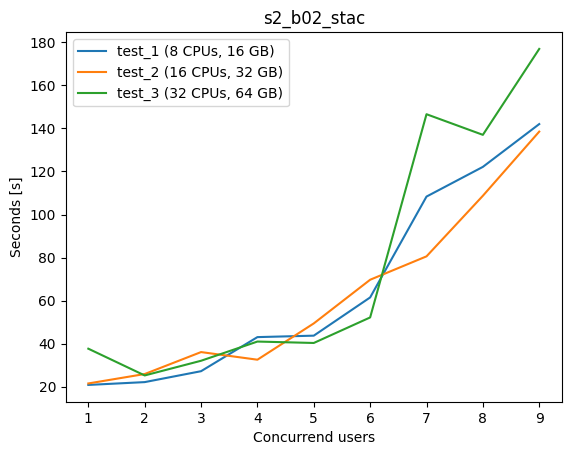

Stats for workflow: s2_b03_stac_expr_cloud_free


{'type': 'Raster',
 'operator': {'type': 'Expression',
  'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }',
   'outputType': 'U16',
   'mapNoData': False},
  'sources': {'a': {'type': 'GdalSource',
    'params': {'data': {'type': 'external',
      'providerId': '5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5',
      'layerId': 'UTM32N:B02'}}},
   'b': {'type': 'GdalSource',
    'params': {'data': {'type': 'external',
      'providerId': '5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5',
      'layerId': 'UTM32N:SCL'}}}}}}

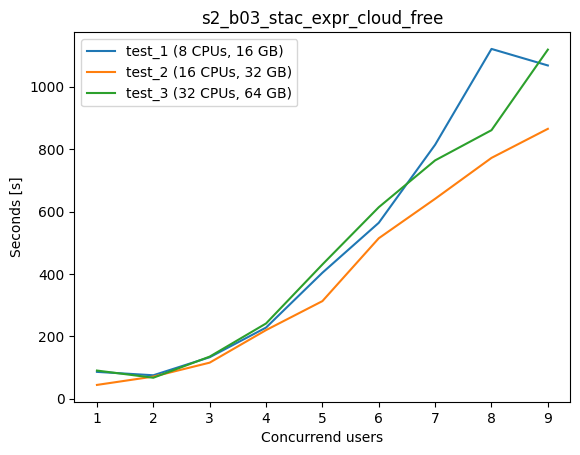

Stats for workflow: s2_b02_local


{'type': 'Raster',
 'operator': {'type': 'GdalSource',
  'params': {'data': {'type': 'internal', 'datasetId': 'AAAAA'}}}}

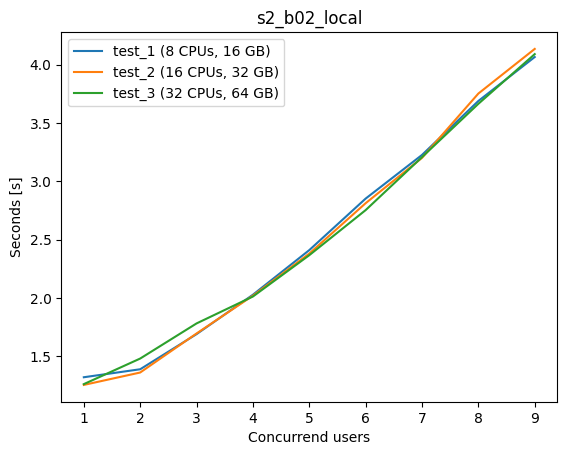

Stats for workflow: s2_b02_local_expr_cloud_free


{'type': 'Raster',
 'operator': {'type': 'Expression',
  'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }',
   'outputType': 'U16',
   'mapNoData': False},
  'sources': {'a': {'type': 'GdalSource',
    'params': {'data': {'type': 'internal', 'datasetId': 'AAAAA'}}},
   'b': {'type': 'GdalSource',
    'params': {'data': {'type': 'internal', 'datasetId': 'BBBBB'}}}}}}

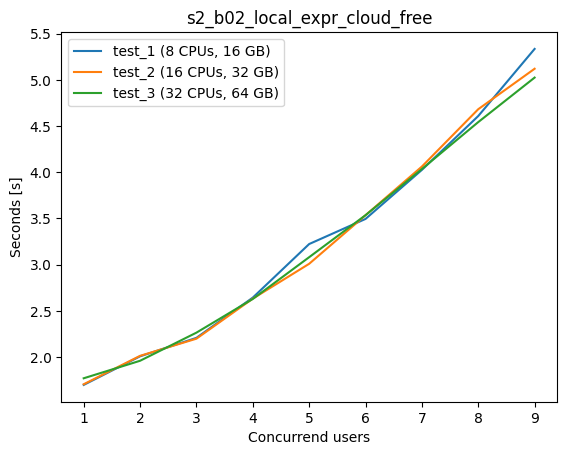

In [71]:
import matplotlib.pyplot as plt
import numpy as np

workflows = list(dummy_workflows.keys())
instances = list(test_instances.keys())

for workflow in workflows:
    print(f"Stats for workflow: {workflow}")
    display(dummy_workflows[workflow].to_workflow_dict())
    fig, ax = plt.subplots()
    ax.set_title(f"{workflow}")
    ax.set_xlabel("Concurrend users")
    ax.set_ylabel("Seconds [s]")
    for instance in instances:
        instance_result = instance_results[(instance, workflow)]
        labels, data = zip(*instance_result.items())
        data_avg = [np.average([ti.total_seconds() for ti in t]) for t in data]
        line, = ax.plot(labels, data_avg)
        cpus = test_instances[instance]["cpus"]
        mem = test_instances[instance]["memory"]
        line.set_label(f"{instance} ({cpus} CPUs, {mem} GB)")
        ax.legend()
    display(fig)
    plt.close()


## Conclusion

From the plots we can see that all test instances perform nearly identical (with some variation).
For the workflows that use the STAC provider, we can see that the variations between the different setups is larger then for the plots which use "local" data. However, the variations might be caused by the download from the AWS S3 buckets.

The most important aspect is the lack of an improovement with more hardware ressources. This might be caused by the low amount of computation requiredby the selected set of workflows or by shared ressources like the ThreadPool.

Further invesigation into this appears neccessary.